<a href="https://colab.research.google.com/github/HakanBayazitHabes/example_CNN_AI/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evrişimli Sinir Ağları (CNN) ile Katı Atık Tespiti



1.   İş Problemi (Business Problem)
2.   Veriyi Anlamak (Data Understanding)
3.   Veriyi Hazırlamak (Data Preparation)
4.   Modelleme (Modelling)
5.   Değerlendirme (Evaluation)




# 1) İş Problemi (Business Problem)

**İş Problemi nedir?**

# 2) Veriyi Anlamak (Data Understanding)

**Veri Seti Hikayesi**

Bu proje kapsamında kullanacağımız veri seti TrashNet isimli veri setidir. Stanford Üniversitesi öğrencileri tarafından hazırlanmıştır.

Veri seti alrı farklı sınıftan oluşmatadır. Veri setinde Cam, Kağıt, Karton, Plastik, Metal ve Çöp olmak üzere toplamda 2527 adet görüntü bulunmaktdır.

Görüntü dağılımı:



*   501 Cam
*   594 kağıt
*   401 Karton
*   482 Plastik
*   410 Metal
*   137 Çöp

Görüntüler, beyaz bir panoya yerleştirilecek ve güneş ışığı veya oda aydınlatması kullanılarak çekilmiştir. Görüntüler, 512x384 piksel boyutlarında ve 3(RGB) kanalıdır.


*   Veri seti hakkında daha fazla bilgi için [Github](https://github.com/garythung/trashnet) sayfasını ziyaret ediniz.
*   Veri setini indirmek için [Kaggle](https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification) sayfasını ziyaret edebilrisiniz.


  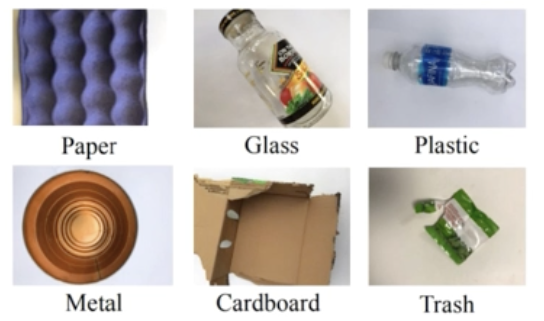



## 2.1) Gerekli Kütüphanelerin Import İşlemleri

In [112]:
# pip install imutils

# Veriyi okuma ve işleme adımında kullanılacak olan kütüphaneler
import cv2
import urllib
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import random, os, glob
from imutils import paths
import matplotlib.pyplot as plt
from sklearn.utils import shuffle



# warningleri kapatmak için kullanılmaktadır.
import warnings
warnings.filterwarnings('ignore')

# Model değerlendirme için kullanılacak olan kütüphaneler
from sklearn.metrics import confusion_matrix, classification_report

# Model için kullanılacak olan kütüphaneler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

## 2.2) Veri Setinin Okunması



1.   Google Colab NoteBook ile Google Drive hesabının eşleştirilmesi
2.   Veri setinin Google Drive'a yüklenmesi ve adresiinin notebook'a gösterilmesi
3.   Veri setini okuyacak fonksiyonun tanımlanması



In [82]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [83]:
# Drive'da bu veri setinde yer alan görüntülerin olduğu path bilgisinin tutulması
dir_path = '/content/drive/MyDrive/Garbage classification'

In [84]:
# Target size ve label Etiket Değerlerinin Belirlenmesi

target_size = (224, 224)

waste_labels = {'cardboard': 0, 'glass': 1, 'metal': 2,'paper': 3, 'plastic': 4, 'trash': 5}

In [85]:
def load_datasets(path):
  """
    Görsellerin bulunduğu dizindeki görüntüyü okuyup etiketlerini oluşturur.

    Parametreler:

    path : Görsellerin bulunduğu dizini ifade eder.

    return:

    x: Görüntülere ait matris bilgilerini tutar.

    labels: Görüntünün ait olduğu sınıf bilgisini tutan liste.
  """

  x = []
  labels = []

  # Gönderdiğimiz pathdeki görüntüleri listeleyip sıralamaktadır.
  image_paths = sorted(list(paths.list_images(path)))


  for image_path in image_paths:
    # Belirlenen pathdeki görüntüler openCV kütüphanesi ile okunmaktadır.
    img = cv2.imread(image_path)

    # Okunan görüntüler başlangıçta elirlenen target_size'a göre yeniden ölçeklendirilir.
    img = cv2.resize(img, target_size)

    # Ölçeklendirilen görüntüler x listesine eklenir.
    x.append(img)

    # Her bir path '/' ifadesi ile ayrıldığında dönen listenin sondan ikinci elemanı labelı temsil etmektedir.
    label = image_path.split(os.path.sep)[-2]

    # Yakalanan labelların sayısal değer karşılıklarının olduğu waste_labels sözlüğü içerisinden gönderilen key
    # değerine karşılık value değeri alınarak label oluşturulur.
    labels.append(waste_labels[label])

  # Veri seti random bir şekilde karıştırılır.
  x, labels = shuffle(x, labels, random_state = 42)

  # Boyut ve Sınıf bilgisi raporlanmaktadır.
  print(f"X boyutu: {np.array(x).shape}")
  print(f"Label sınıf sayısı: {len(np.unique(labels))}  Gözlem sayısı: {len(labels)}")

  return x, labels

In [86]:
x, labels = load_datasets(dir_path)

X boyutu: (2527, 224, 224, 3)
Label sınıf sayısı: 6  Gözlem sayısı: 2527


In [87]:
# Görüntü boyutlarının tutulması
input_shape = (np.array(x[0]).shape[1], np.array(x[0]).shape[1], 3)
print(input_shape)

(224, 224, 3)


## 2.3) Veri Setinden Örnekler Gösterilmesi

In [88]:
def visualize_img(image_batch, label_batch):
  """
    Veri seti içerisinden görüntü görselleştirilir.

    Parametreler:

    image_batch: Görüntülere ait matris bilgilerini tutar.

    label_batch: Görüntünün ait olduğu sınıf bilgisini tutan liste.

  """

  plt.figure(figsize=(10,10))
  for n in range(10):
    ax = plt.subplot(5,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(np.array(list(waste_labels.keys()))[to_categorical(labels, num_classes = 6)[n]==1][0].title())
    plt.axis('off')



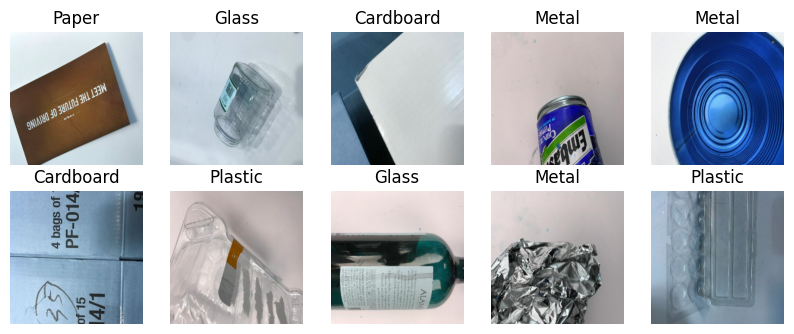

In [89]:
visualize_img(x, labels)

# 3) Veriyi Hazırlamak (Data Preparation)

In [90]:
# Train veri seti için bir generator tanımlıyoruz
# Fotoğraflar bir oda içersinde beyaz bir zemin üzerinde çekildiğinden dolayı gerçek dünyadan uzaktır.
# Gerçek dünya da beyaz zemin ve aydınlatılmış. bir ortam olmayıcağından dolayı bu katı atıklar
# bu sebeple bu görüntülerin gerçek hayata yakın özelliklerle çeşitlendirilmesi gerekmektedir.
train = ImageDataGenerator(horizontal_flip=True,
                           vertical_flip=True,
                           validation_split=0.1,
                           rescale=1./255,
                           shear_range=0.1,
                           zoom_range=0.1,
                           width_shift_range=0.1,
                           height_shift_range=0.1)

# Test veri seti için bir generator tanımlıyoruz
test = ImageDataGenerator(rescale=1/255,
                          validation_split=0.1)


In [91]:
train_generator= train.flow_from_directory(directory=dir_path,
                                           target_size=(target_size),
                                           class_mode='categorical',
                                           subset = 'training')
# class_mode daki categorical birden fazla classımızın olduğunu anlayacaktır. İkili sınıflandırma yapsaydık binary ifadesi kullanacaktık.

test_generator = test.flow_from_directory(directory=dir_path,
                                          target_size = (target_size),
                                          batch_size=251,
                                          class_mode='categorical',
                                           subset = 'validation')

# batch_size ile test setinin boyut bilgisini girmiş olduk.

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


# 4) Modelleme (Modeling)

## 4.1) Sıfırdan CNN Modeli Kurma


*   Sequential
*   Evrişim Katmanı (Convolution Layer, Conv2D)
*   Havuzlama Katmanı (Pooling Layer)
*   Aktivasyon Fonksiyonu Katmanı (Activation Layer)
*   Flattening Katmanı
*   Dense Katmanı
*   Dropout Katmanı



In [92]:
# ------ Sequential Layer --------
model = Sequential()

# ------ Evrişimli Katmanı --------
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=(input_shape), activation='relu'))
# filters = 32 => bir gmrüntü üzerinde gezilecek filtre sayısını temsil eder.
# kernek_size => Gezdirilecek olan filtrenin boyut bilgisini ifade etmekdtedir.
# paddding='name' => Çıkış matrisi ile giriş matrisin aynı genişilk ve yükseklik boyuta sahip olacak
# şekilde girdinin sağına soluna veya aşağısına veya yukarısına eşit olarak 0 piksel değerleri yerleştirilecektir.
# input_shape => Giriş ifadelerinin boyut bilgisini ifade etmektedir.
# activation => Aktivasyon fonksiyonumuzu ifade etmektedir.

# ------ Pooling Layer --------
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

# Pooling işlemi görüntünün özelliklerini kaybetmeden boyutunun azaltılması işlemidir.
# Bu katmanda öğrenme işlemi yapılmamaktadır.
# MaxPooling => Evrişim işlemi sonrasında çıktı matrisi üzerinde filtrenin gezmiş olduğu noktaların max değerleri alınarak çıktı matrisi oluşturlmaktadır
# pool_size => görüntü matrisi üzerinde gezdirilecek olan filtrenin boyut bilgisini ifade eder.
# strides => görüntü(giriş) matrisi üzerinde adım sayısını ifade eder.

# ------- Flatten Katmanı --------
model.add(Flatten())
# Flatten katmanı matrislerin tek boyutlu bir diziye çevrilme işlemidir.
# Verilerimizi tam olarak yapay sinir ağın girişlerine uygun hale getirme görevini görmektedir.

# -------- Dense Katmanı ---------
model.add(Dense(units=64, activation='relu'))
# Katmanlar arasında nöron ya da düğümlerin geçişelrini sağlamaktadır.
# Bir katmandan aldığı nöronların bir sonraki katmana girdi olarak bağlanmasını sağlar.
# units => Kaç tane nöron olacağını ifade etmektedir.
# Bu katmandan sonra çıktı gerçeklirilecek olduğunda aktivasyon fonksiyonun ne olacağı bilgisinin relu olacağı bilgisini ifade ediyoruz.

# -------- Dropout Katmanı ---------
model.add(Dropout(rate=0.2))
# Aşırı öğrenmenin önüne geçmek için yani overfitten önüne geçmek için kullanılan bir argümandır.
# Sinir ağı içersinde yer alan nöronların kullanıcı tarafından belirlenen bir oranda rastgele söndürülmesiyle aşırı öğrenmeyi önler.
# sinir ağın performansını arttırmış olur.

model.add(Dense(units=32, activation='relu'))
model.add(Dropout(rate=0.2))

# --------- Çıktı Katmanı ----------
model.add(Dense(units=6, activation='softmax'))
# 6 sınıfımız olduğu için nöron sayısını altı yaptık
# 2'den fazla sınıf kullandığımız için aktivasyon fonksiyonumuzu softmax olarak ayarladık.
# 2 sınıfımız olsaydı sigmoid aktivasyon kullanamız gerekmeydi.



## 4.2 Model Özeti

In [93]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 56, 56, 32)        18464     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 28, 28, 32)       

<h1><center><img src="https://drive.google.com/uc?id=1WEV0j8pEmQltEi9goRRoGvaQYRgTE7GX" width="2000"></center></h1>


***Evrişim Katmanları =>*** görüntüden özellik çıkarmak için kullanılan katmanlar

***Pooling Katmanı =>*** görüntüden özellik çıkarmayı destekleyen ara katmanlar

***Not:*** Her evrişimden sonra pooling işlemi yapılır. Görüntüden alacak olduğumuz özelliği boyut indirgiyerek yapıyoruz.


CNN özelinde olan katmanlardan sonra flatten karmanından sonra klasik sinir ağ(ANN) yapısına geçmiş oluyoruz.

Klasik sinir ağ mimariisnde nöronlar var. 64 nöronluk bir katman bu, bu katmanda aşırı öğrenmenin önüne geçmek için dropout işlemi yaptık.

Bir katman daha ekledik 32 nörondan oluşan sonra aşırı öğrenmenin önüne geçmek için dropout işlemi yaptık.

Bir katman daha ekleyerek çıkış. Katmanı oluşturduk.

## 4.3) Optimizasyon ve Değerlerndirme Metriklerinin Ayarlanması

In [94]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), "acc"])

# 2 den fazla sınıf çalışacağım için categorical_crossentropy yöntemini kullandık.
# 2 sınıf olsaydı binarycal_crosentropy kullanılırdı.

In [95]:
callbacks = [EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode="min"),
             ModelCheckpoint(filepath='mymodel.h5', monitor='val_loss', mode='min', save_best_only=True, save_weights_only=False)]

# EarlyStopping = Model ezberleyeme başlamıssa erkenden durdurur.

## 4.4) Modelin Eğitilmesi

In [96]:
history = model.fit_generator(generator=train_generator,
                              epochs=30,
                              validation_data=test_generator,
                              callbacks=callbacks,
                              workers=4,
                              steps_per_epoch=2276//32,
                              validation_steps=251//32)

# workers => donanımsal bir ifaderdir. Paralel olarak gruplar oluşturan iş parçacığı sayısıdır.
# callbacks => Model eğitme aşamasındaki aşırı öğrenmenin önüne geçilir.
# steps_per_epoch => bir epoch tamamlandığında ve bir sonraki epoch'un bildirmeden önceki toplam adım sayısını ifade eder.
# Her epoch'da 71 sample da model eğitimi gerçekleştrilecektir.
# validation_steps => steps_per_epoch deki mantık aynen geçerlidir.

Epoch 1/30
71/71 [==============================] - 45s 555ms/step - loss: 1.7366 - precision_2: 0.2222 - recall_2: 0.0018 - acc: 0.2424 - val_loss: 1.6587 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_acc: 0.2669
Epoch 2/30
71/71 [==============================] - 41s 570ms/step - loss: 1.6282 - precision_2: 0.6143 - recall_2: 0.0383 - acc: 0.3026 - val_loss: 1.4851 - val_precision_2: 0.7419 - val_recall_2: 0.0916 - val_acc: 0.3665
Epoch 3/30
71/71 [==============================] - ETA: 0s - loss: 1.5003 - precision_2: 0.7022 - recall_2: 0.1292 - acc: 0.3890

KeyboardInterrupt: ignored

## 4.5) Accuracy ve Loss Grafikleri

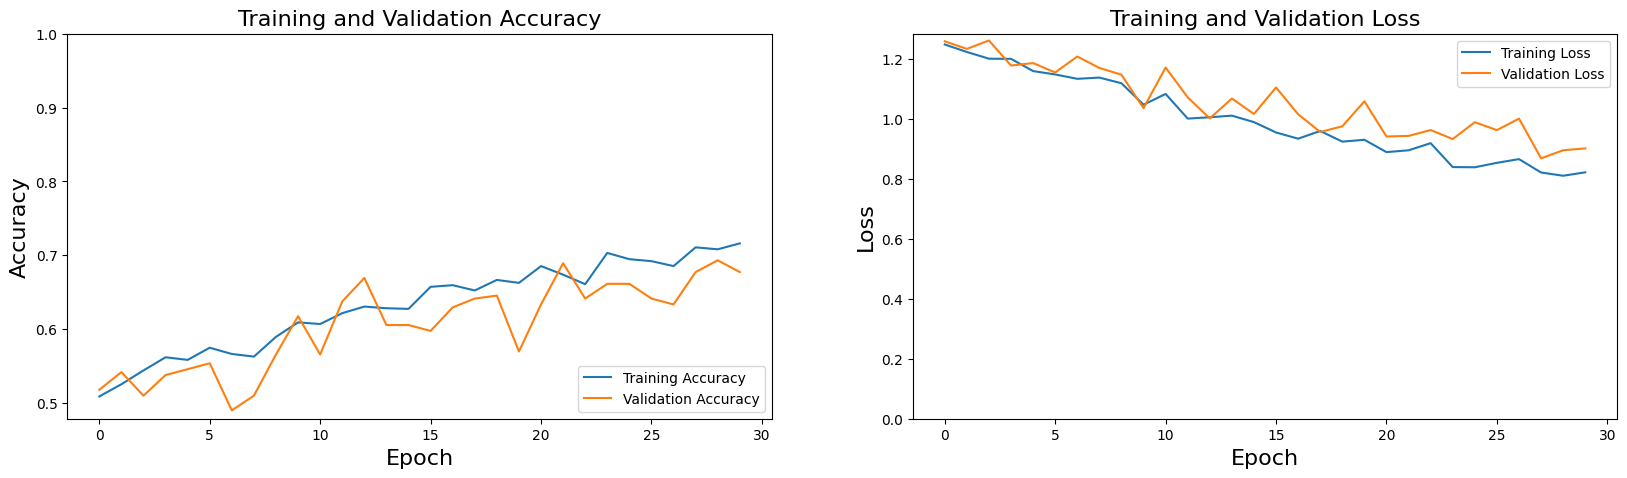

In [97]:
# --------------
#  Accuracy Grafiği
# --------------

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy', fontsize=16)

# -------------
# Loss Grafiği
# -------------

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss', fontsize=16)
plt.show()

# 5) Değerlendirme (Evaluation)

In [98]:
loss, precision, recall, acc = model.evaluate(test_generator, batch_size=32)

1/1 [==============================] - 1s 975ms/step - loss: 1.3882 - precision_2: 0.8571 - recall_2: 0.1673 - acc: 0.4024


In [100]:
print("\nTest Accuracy: %.1f%%" % (100.0 * acc))
print("\nTest loss: %.f%%" % (100.0 * loss))
print("\nTest pricision : %.1f%%" % (100.0 * precision))
print("\nTest recall : %.1f%%" % (100.0 * recall))



Test Accuracy: 40.2%

Test loss: 139%

Test pricision : 85.7%

Test recall : 16.7%


In [101]:
# Calssificaiton Report
x_test, y_test = test_generator.next()

y_pred = model.predict(x_test)

y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

8/8 [==============================] - 0s 18ms/step


In [102]:
target_names = list(waste_labels.keys())

In [103]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   cardboard       0.55      0.70      0.62        40
       glass       0.26      0.10      0.14        50
       metal       0.36      0.10      0.15        41
       paper       0.49      0.56      0.52        59
     plastic       0.30      0.65      0.41        48
       trash       0.00      0.00      0.00        13

    accuracy                           0.40       251
   macro avg       0.33      0.35      0.31       251
weighted avg       0.37      0.40      0.35       251



In [104]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusing matrix.
  Normalization can be applied by setting normalize = True
  """

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  plt.figure(figsize=(8, 6))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j]> thresh else "black")
  plt.tight_layout()
  plt.ylabel('True label', fontweight="bold")
  plt.xlabel('Predicted label', fontweight="bold")




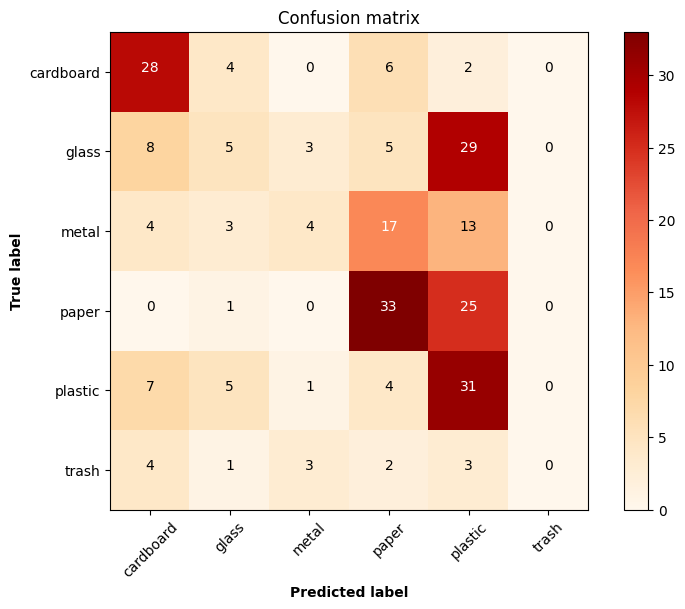

In [105]:
plot_confusion_matrix(cm, waste_labels.keys(),
                      title='Confusion matrix',
                      cmap=plt.cm.OrRd)


# Modelin Kullanılması / Test Edilmesi

In [116]:
waste_labels = {0:'cardboard' , 1: 'glass', 2:'metal',3:'paper', 4:'plastic', 5:'trash'}

In [117]:
def model_testing(path):
  '''
  Görsellerin bulunduğu diizndeki görüntüyü okuyup model aracılığıyla ile hangi sınıfa ait olduğunu dair tahmin işlemi gerçekleştirlir.

  Parametreler:

  path : Görsellerin bulunduğu dizini ifade eder.

  Return:

  img: Görüntü

  p: Tahmin olasılıkları

  predicted_class: Tahmin sınıfı

  '''

  img = image.load_img(path, target_size=(target_size))
  img = image.img_to_array(img, dtype=np.uint8)
  img = np.array(img)/255.0
  p = model.predict(img.reshape(1, 224, 224, 3))
  predicted_class = np.argmax(p[0])

  return img, p, predicted_class


img1, p1, predicted_class1 = model_testing('/content/drive/MyDrive/Garbage classification/metal/metal100.jpg')
img2, p2, predicted_class2 = model_testing('/content/drive/MyDrive/Garbage classification/glass/glass105.jpg')
img3, p3, predicted_class3 = model_testing('/content/drive/MyDrive/Garbage classification/cardboard/cardboard103.jpg')
img4, p4, predicted_class4 = model_testing('/content/drive/MyDrive/Garbage classification/paper/paper106.jpg')

1/1 [==============================] - 0s 21ms/step


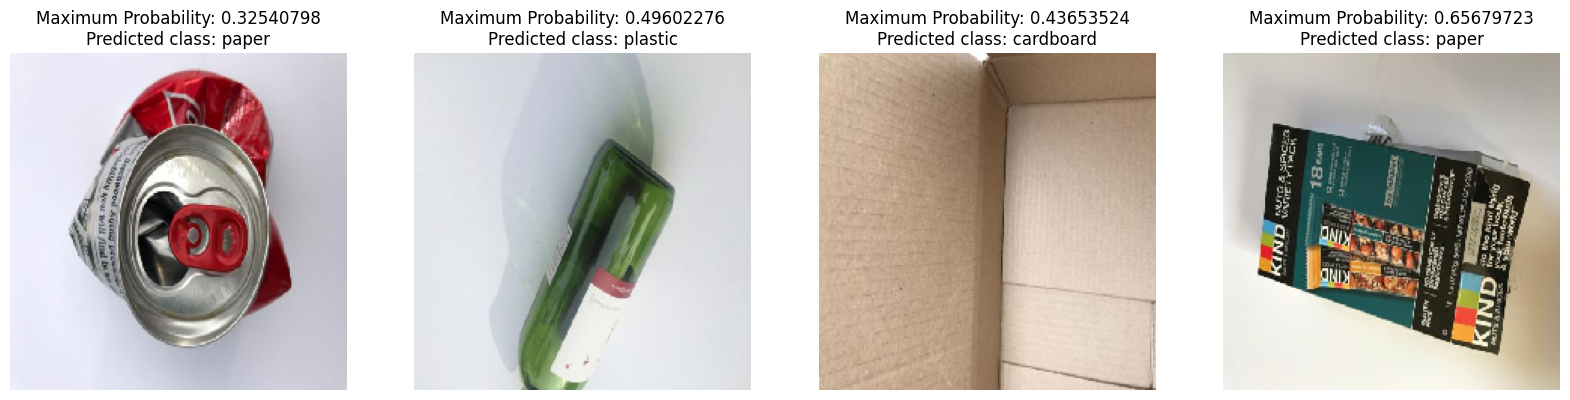

In [118]:
plt.figure(figsize=(20, 60))

plt.subplot(141)
plt.axis('off')
plt.imshow(img1.squeeze())
plt.title("Maximum Probability: " + str(np.max(p1[0], axis=-1)) + "\n" + "Predicted class: " + str(waste_labels[predicted_class1]))
plt.imshow(img1)

plt.subplot(142)
plt.axis('off')
plt.imshow(img2.squeeze())
plt.title("Maximum Probability: " + str(np.max(p2[0], axis=-1)) + "\n" + "Predicted class: " + str(waste_labels[predicted_class2]))
plt.imshow(img2)

plt.subplot(143)
plt.axis('off')
plt.imshow(img3.squeeze())
plt.title("Maximum Probability: " + str(np.max(p3[0], axis=-1)) + "\n" + "Predicted class: " + str(waste_labels[predicted_class3]))
plt.imshow(img3)

plt.subplot(144)
plt.axis('off')
plt.imshow(img4.squeeze())
plt.title("Maximum Probability: " + str(np.max(p4[0], axis=-1)) + "\n" + "Predicted class: " + str(waste_labels[predicted_class4]))
plt.imshow(img4)